In [2]:
# Importing main libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path
from tqdm.auto import tqdm
from types import SimpleNamespace
import os
from PIL import Image
import csv
import json

In [4]:
meta = SimpleNamespace(base_dir = Path('C:/Users/dodge/Desktop/Marchegiani/Progetto/Dataset/'))
meta.label_path = meta.base_dir / 'data_object_label_2_unzipped' / 'training' / 'label_2'
meta.img_path = meta.base_dir / 'data_object_image_2_unzipped' / 'training' / 'image_2'
meta.ims = sorted(list(meta.img_path.glob('*')))
meta.labels = sorted(list(meta.label_path.glob('*')))
meta.label_colors = {
    'Car': (255,0,0), 
    'Van': (255,255,0), 
    'Truck': (255,255,255),
    'Pedestrian': (0,255,255),
    'Person_sitting': (0,255,255), 
    'Cyclist': (0,128,255), 
    'Tram': (128,0,0),
    'Misc': (0,255,255),
    'DontCare': (255,255,0)
}
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha', 
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]

meta.df = pd.DataFrame({
    'image': meta.ims,
    'label': meta.labels
})

meta.im_width = 256
meta.im_height: 160

In [5]:
# An example of original kitti dataset labels of an image
def get_label(p):
    data =  pd.read_csv(
        p, 
        sep=" ",
        names=meta.label_cols[:15],
        usecols = meta.label_cols[:15]
    )
    return data

get_label(meta.df['label'][55])

,label,truncated,occluded,alpha,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,dim_height,dim_width,dim_length,loc_x,loc_y,loc_z,rotation_y
0,Truck,0.0,0,-1.56,569.25,125.75,642.77,214.80,3.52,2.89,10.81,-0.18,1.71,34.15,-1.57
1,Car,0.0,1,2.24,31.61,193.32,129.71,230.77,1.48,1.35,3.93,-23.47,2.44,32.12,1.62
2,Car,0.0,1,2.14,104.42,188.01,188.34,220.56,1.50,1.62,4.08,-23.45,2.30,36.62,1.58
3,Car,0.0,1,2.08,183.23,187.33,245.86,217.54,1.65,1.57,3.82,-23.27,2.53,42.56,1.58
4,Car,0.0,1,2.04,227.36,189.17,281.98,211.96,1.37,1.36,4.44,-23.40,2.48,47.64,1.59
5,DontCare,-1.0,-1,-10.00,493.86,154.57,525.19,183.59,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00
6,DontCare,-1.0,-1,-10.00,645.63,163.86,684.67,184.57,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


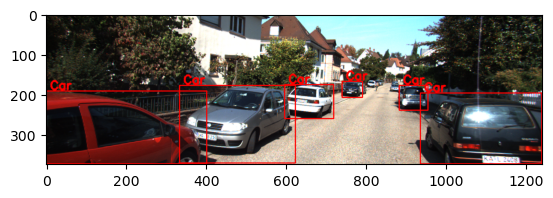

In [6]:
# Defining bounding boxes
def open_image(p):
    im = cv.imread(str(p))
    im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
    return im

def draw_box2d(idx, ax = None):
    sample = meta.df.iloc[idx,:]
    img = open_image(sample['image'])
    labels = get_label(sample['label'])
    for index, row in labels.iterrows():
        left_corner = (int(row.bbox_xmin), int(row.bbox_ymin))
        right_corner = (int(row.bbox_xmax), int(row.bbox_ymax))
        
        if row.label == 'DontCare':
            continue
        
        label_color = meta.label_colors.get(row.label,(0,255,0))
        img = cv.rectangle(img,left_corner, right_corner, label_color, 2)
        img = cv.putText(img, row.label, 
                          (left_corner[0] + 10, left_corner[1] - 4) , 
                          cv.FONT_HERSHEY_SIMPLEX, 1, 
                          label_color, 3)
    
    if ax == None:
        plt.imshow(img)
    else:
        ax.imshow(img)
# Example:
draw_box2d(8)

In [9]:
all_classes = []

OUT_LABELS_DIR = "labels_with_dont_care"

KEY_DONT_CARE = "DontCare"

class_names = ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting', 'DontCare']

CLAZZ_NUMBERS = {
    name: idx for idx,name in enumerate(class_names)
}

def getSampleId(path):
    basename = os.path.basename(path)
    return os.path.splitext(basename)[0]

def resolveClazzNumberOrNone(clazz, use_dont_care):
#     if clazz == KEY_CYCLIST:
#         return CLAZZ_NUMBERS[KEY_CYCLIST]
#     #if clazz in (KEY_PEDESTRIAN, KEY_PERSON_SITTING):
#     if clazz == KEY_PEDESTRIAN:
#         return CLAZZ_NUMBERS[KEY_PEDESTRIAN]
#     #if clazz in (KEY_CAR, KEY_VAN):
#     if clazz == KEY_CAR:
#         return CLAZZ_NUMBERS[KEY_CAR]
#     if use_dont_care and clazz == KEY_DONT_CARE:
#         return CLAZZ_NUMBERS[KEY_DONT_CARE] # These should not be punished.
    if use_dont_care and clazz == KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    elif clazz != KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    return None
def convertToYoloBBox(bbox, size):
    # Yolo uses bounding bbox coordinates and size relative to the image size.
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0
    y = (bbox[2] + bbox[3]) / 2.0
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def readRealImageSize(img_path):
    # This loads the whole sample image and returns its size.
    return Image.open(img_path).size

def readFixedImageSize():
    # This is not exact for all images but most (and it should be faster).
    return (1242, 375)

def parseSample(lbl_path, img_path, use_dont_care):
    with open(lbl_path) as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
        yolo_labels = []
        for row in reader:
            all_classes.append(row['type'])
            clazz_number = resolveClazzNumberOrNone(row["type"], use_dont_care)
            if clazz_number is not None:
                size = readRealImageSize(img_path)
                #size = readFixedImageSize()
                # Image coordinate is in the top left corner.
                bbox = (
                        float(row["bbox2_left"]),
                        float(row["bbox2_right"]),
                        float(row["bbox2_top"]),
                        float(row["bbox2_bottom"])
                       )
                yolo_bbox = convertToYoloBBox(bbox, size)
                # Yolo expects the labels in the form:
                # <object-class> <x> <y> <width> <height>.
                yolo_label = (clazz_number,) + yolo_bbox
                yolo_labels.append(yolo_label)
    return yolo_labels


args = SimpleNamespace(
    label_dir = str(meta.label_path),
    image_2_dir = str(meta.img_path),
    training_samples = 1,
    use_dont_care = True
)

if not os.path.exists(OUT_LABELS_DIR):
    os.makedirs(OUT_LABELS_DIR)

print("Generating darknet labels...")
sample_img_pathes = []
for dir_path, sub_dirs, files in os.walk(args.label_dir):
    for file_name in tqdm(files):
        if file_name.endswith(".txt"):
            lbl_path = os.path.join(dir_path, file_name)
            sample_id = getSampleId(lbl_path)
            img_path = os.path.join(args.image_2_dir, "{}.png".format(sample_id))
            sample_img_pathes.append(img_path)
            yolo_labels = parseSample(lbl_path, img_path, args.use_dont_care)
            with open(os.path.join(OUT_LABELS_DIR, "{}.txt".format(sample_id)), "w") as yolo_label_file:
                for lbl in yolo_labels:
                    yolo_label_file.write("{} {} {} {} {}\n".format(*lbl))

Generating darknet labels...


  0%|          | 0/7481 [00:00<?, ?it/s]

In [8]:
with open('classes_with_dont_care.json','w') as f:
    json.dump(CLAZZ_NUMBERS,f)
    
CLAZZ_NUMBERS

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}